<a href="https://colab.research.google.com/github/viniventur/previsao_artigo_HW_SARIMA/blob/main/testes_robustez_SARIMA_artigo_hw_sarima_anpec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudo de previsão de receitas utilizando SARIMA para os ICMS e IPVA

# Librarys utilizadas

In [49]:
!pip install pmdarima arch -q

In [50]:
import pandas as pd
import numpy as np
import scipy
import pmdarima as pm
import itertools
from itertools import product
from google.colab import drive
drive.mount('/content/drive')
import statsmodels.api as sm
import os
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.dates import YearLocator
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager
import matplotlib as mpl
import matplotlib.ticker as mticker
from datetime import datetime
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import seaborn as sns
import warnings
import arch
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

# Previsão
from statsmodels.tsa.api import SimpleExpSmoothing,Holt,ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot
from scipy import stats
from scipy.stats import boxcox

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf

from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.forecasting.stl import STLForecast

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Tratando dados

In [51]:
df = pd.read_excel("/content/drive/MyDrive/Gerência de Estudos e Projeções/Dados/Impostos/Impostos - ICMS - ITCD - IPVA - IRRF - 1999 - 2024.xlsx", sheet_name='dados_1999_2024')
df['Total'] = df.ICMS + df.IPVA + df.IRRF + df.ITCD
df

,ANO,MES,ICMS,IPVA,ITCD,IRRF,Total
0,1999,1,4.035843e+07,658956.65,21163.97,3.293230e+03,4.104184e+07
1,1999,2,3.894808e+07,1032605.36,13089.30,8.150040e+03,4.000192e+07
2,1999,3,3.194334e+07,2489990.52,26279.08,0.000000e+00,3.445961e+07
3,1999,4,3.415198e+07,1851256.22,42705.30,0.000000e+00,3.604594e+07
4,1999,5,3.282836e+07,1905139.44,27892.99,0.000000e+00,3.476139e+07
...,...,...,...,...,...,...,...
302,2024,3,6.412978e+08,46837316.37,3990607.28,7.723583e+07,7.693616e+08
303,2024,4,6.901577e+08,64609203.08,4789282.70,8.712705e+07,8.466832e+08
304,2024,5,6.356771e+08,73725244.53,4528985.51,9.139155e+07,8.053229e+08
305,2024,6,6.307851e+08,71891371.15,5737256.86,1.084689e+08,8.168826e+08


In [52]:
# Limpando a base
df.dropna(inplace=True)
df['Data'] = pd.to_datetime(df['ANO'].astype(str) + '-' + df['MES'].astype(str))
df = df.set_index("Data")
df = df.drop(['MES', 'ANO'], axis=1)
df = df.loc[(df.index >= '2008-01-01') & (df.index <= '2024-12-01')] # inicio definido em 01-2008 e fim definido em 12-2023
df

,ICMS,IPVA,ITCD,IRRF,Total
Data,,,,,
2008-01-01,1.435041e+08,3089289.71,272955.72,4.840761e+05,1.473504e+08
2008-02-01,1.339496e+08,4518615.04,110671.20,8.355140e+06,1.469340e+08
2008-03-01,1.263094e+08,6134471.17,215239.97,1.906390e+07,1.517230e+08
2008-04-01,1.245758e+08,8201420.84,207046.89,1.104372e+07,1.440280e+08
2008-05-01,1.288502e+08,8670808.35,239724.30,1.093729e+07,1.486980e+08
...,...,...,...,...,...
2024-02-01,6.385334e+08,40180682.59,5812958.30,8.310542e+07,7.676325e+08
2024-03-01,6.412978e+08,46837316.37,3990607.28,7.723583e+07,7.693616e+08
2024-04-01,6.901577e+08,64609203.08,4789282.70,8.712705e+07,8.466832e+08


In [53]:
df = df[['ICMS', 'IPVA']]
df

,ICMS,IPVA
Data,,
2008-01-01,1.435041e+08,3089289.71
2008-02-01,1.339496e+08,4518615.04
2008-03-01,1.263094e+08,6134471.17
2008-04-01,1.245758e+08,8201420.84
2008-05-01,1.288502e+08,8670808.35
...,...,...
2024-02-01,6.385334e+08,40180682.59
2024-03-01,6.412978e+08,46837316.37
2024-04-01,6.901577e+08,64609203.08


In [54]:
df_icms = df['ICMS']
df_ipva = df['IPVA']

# TESTE 1 (MESMO CORTE TEMPORAL COM 22 OBS PRA FRENTE)

In [55]:
# treino e real
df_treino = df.loc[(df.index >= '2008-01-01') & (df.index <= '2022-08-01')]
df_real = df.loc[(df.index >= '2022-09-01')]

## ICMS

In [56]:
# ICMS
icms_order_aic = (0,1,1)
icms_seasonal_order_aic = (0,1,1,12)
icms_order_mape = (1,1,1)
icms_seasonal_order_mape = (1,0,0,12)
# IPVA
ipva_order_aic = (1,1,1)
ipva_seasonal_order_aic = (0,1,0,12)
ipva_order_mape = (1,0,1)
ipva_seasonal_order_mape = (0,1,0,12)

### AIC

In [57]:
# AIC

sarima_icms = pm.ARIMA(order = icms_order_aic, seasonal_order = icms_seasonal_order_aic, suppress_warnings=True)
sarima_icms.fit(df_treino['ICMS'])
prev_icms_aic = sarima_icms.predict(n_periods= 22, return_conf_int=False)
prev_icms_aic = pd.DataFrame(prev_icms_aic, columns=['Previsão Modelo 1'])
# ICMS

# Utilizando z-score de distribuição normal
n = len(prev_icms_aic)
prev_icms_aic['error'] = df_real['ICMS'] - prev_icms_aic['Previsão Modelo 1']
s = prev_icms_aic['error'].std(ddof=1)
t = stats.t.ppf(0.975, df=n-1)

prev_icms_aic['conf_interval'] = t * s / np.sqrt(n)
prev_icms_aic['pred_interval'] = t * s * np.sqrt(1 + 1/n)

# Calculando limites superiores e inferiores para cada previsão
prev_icms_aic['conf_lower'] = prev_icms_aic['Previsão Modelo 1'] - prev_icms_aic['conf_interval']
prev_icms_aic['conf_upper'] = prev_icms_aic['Previsão Modelo 1'] + prev_icms_aic['conf_interval']
prev_icms_aic['pred_lower'] = prev_icms_aic['Previsão Modelo 1'] - prev_icms_aic['pred_interval']
prev_icms_aic['pred_upper'] = prev_icms_aic['Previsão Modelo 1'] + prev_icms_aic['pred_interval']
prev_icms_aic

,Previsão Modelo 1,error,conf_interval,pred_interval,conf_lower,conf_upper,pred_lower,pred_upper
2022-09-01,4.673349e+08,-1.567586e+07,2.985908e+07,1.431991e+08,4.374758e+08,4.971940e+08,3.241358e+08,6.105341e+08
2022-10-01,4.956640e+08,-4.219143e+06,2.985908e+07,1.431991e+08,4.658049e+08,5.255230e+08,3.524648e+08,6.388631e+08
2022-11-01,5.174248e+08,-1.666739e+07,2.985908e+07,1.431991e+08,4.875657e+08,5.472839e+08,3.742257e+08,6.606240e+08
2022-12-01,5.663836e+08,-4.867763e+07,2.985908e+07,1.431991e+08,5.365245e+08,5.962427e+08,4.231845e+08,7.095827e+08
2023-01-01,5.488806e+08,-2.979401e+07,2.985908e+07,1.431991e+08,5.190215e+08,5.787397e+08,4.056814e+08,6.920797e+08
2023-02-01,5.090255e+08,-1.757461e+07,2.985908e+07,1.431991e+08,4.791664e+08,5.388846e+08,3.658264e+08,6.522246e+08
2023-03-01,4.681865e+08,2.385181e+07,2.985908e+07,1.431991e+08,4.383274e+08,4.980456e+08,3.249873e+08,6.113856e+08
2023-04-01,5.012768e+08,2.277357e+07,2.985908e+07,1.431991e+08,4.714177e+08,5.311358e+08,3.580776e+08,6.444759e+08
2023-05-01,4.769867e+08,5.999945e+07,2.985908e+07,1.431991e+08,4.471277e+08,5.068458e+08,3.337876e+08,6.201859e+08
2023-06-01,4.930216e+08,6.099345e+07,2.985908e+07,1.431991e+08,4.631625e+08,5.228807e+08,3.498225e+08,6.362208e+08


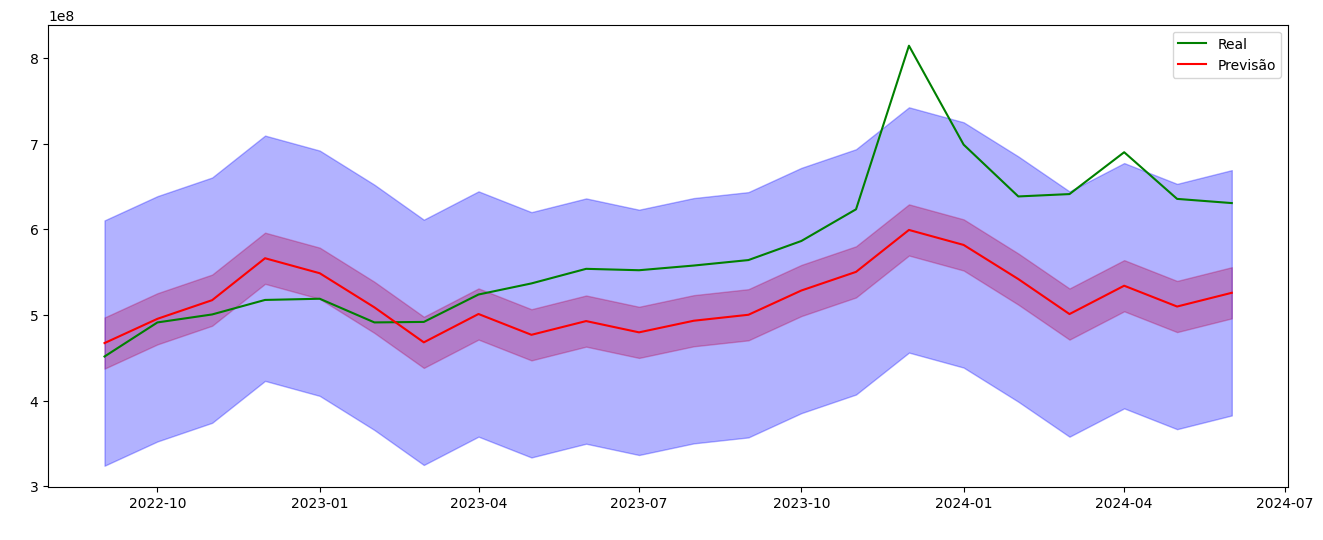

In [58]:
plt.figure(figsize = (16,6))
#plt.title('Previsão do ICMS com base na metodologia de Box-Jenkins', size = 18)
plt.ylabel(' ')
plt.xlabel(' ')
plt.legend(['Valor Real', 'Previsão'])
sns.lineplot(x = df_real.loc[df_real.index >= '2022-09-01'].index,
             y = df_real.loc[df_real.index >= '2022-09-01'].ICMS,
             color = 'green',
             label = 'Real')
sns.lineplot(x = prev_icms_aic.index,
             y = prev_icms_aic['Previsão Modelo 1'],
             color = 'red',
             label = 'Previsão')
plt.fill_between(prev_icms_aic.index, prev_icms_aic['conf_lower'], prev_icms_aic['conf_upper'], alpha = 0.3, color = 'Red')
plt.fill_between(prev_icms_aic.index, prev_icms_aic['pred_lower'], prev_icms_aic['pred_upper'], alpha = 0.3, color = 'Blue')

In [59]:
mape_icms_aic_1 = MAPE(prev_icms_aic['Previsão Modelo 1'], df_real['ICMS'])*100
mape_icms_aic_1

13.641613840330402

### MAPE

In [60]:
# MAPE

sarima_icms = pm.ARIMA(order = icms_order_mape, seasonal_order = icms_seasonal_order_mape, suppress_warnings=True)
sarima_icms.fit(df_treino['ICMS'])
prev_icms_mape = sarima_icms.predict(n_periods= 22, return_conf_int=False)
prev_icms_mape = pd.DataFrame(prev_icms_mape, columns=['Previsão Modelo 1'])
# ICMS

# Utilizando z-score de distribuição normal
n = len(prev_icms_mape)
prev_icms_mape['error'] = df_real['ICMS'] - prev_icms_mape['Previsão Modelo 1']
s = prev_icms_mape['error'].std(ddof=1)
t = stats.t.ppf(0.975, df=n-1)

prev_icms_mape['conf_interval'] = t * s / np.sqrt(n)
prev_icms_mape['pred_interval'] = t * s * np.sqrt(1 + 1/n)

# Calculando limites superiores e inferiores para cada previsão
prev_icms_mape['conf_lower'] = prev_icms_mape['Previsão Modelo 1'] - prev_icms_mape['conf_interval']
prev_icms_mape['conf_upper'] = prev_icms_mape['Previsão Modelo 1'] + prev_icms_mape['conf_interval']
prev_icms_mape['pred_lower'] = prev_icms_mape['Previsão Modelo 1'] - prev_icms_mape['pred_interval']
prev_icms_mape['pred_upper'] = prev_icms_mape['Previsão Modelo 1'] + prev_icms_mape['pred_interval']
prev_icms_mape

,Previsão Modelo 1,error,conf_interval,pred_interval,conf_lower,conf_upper,pred_lower,pred_upper
2022-09-01,4.662481e+08,-1.458900e+07,2.949857e+07,1.414702e+08,4.367495e+08,4.957466e+08,3.247779e+08,6.077182e+08
2022-10-01,4.905318e+08,9.130243e+05,2.949857e+07,1.414702e+08,4.610332e+08,5.200304e+08,3.490616e+08,6.320020e+08
2022-11-01,4.986097e+08,2.147703e+06,2.949857e+07,1.414702e+08,4.691112e+08,5.281083e+08,3.571396e+08,6.400799e+08
2022-12-01,5.161105e+08,1.595507e+06,2.949857e+07,1.414702e+08,4.866119e+08,5.456090e+08,3.746403e+08,6.575806e+08
2023-01-01,5.181786e+08,9.079692e+05,2.949857e+07,1.414702e+08,4.886800e+08,5.476772e+08,3.767084e+08,6.596488e+08
2023-02-01,5.061377e+08,-1.468679e+07,2.949857e+07,1.414702e+08,4.766391e+08,5.356362e+08,3.646675e+08,6.476078e+08
2023-03-01,4.881913e+08,3.846963e+06,2.949857e+07,1.414702e+08,4.586927e+08,5.176899e+08,3.467211e+08,6.296615e+08
2023-04-01,5.279839e+08,-3.933524e+06,2.949857e+07,1.414702e+08,4.984853e+08,5.574824e+08,3.865137e+08,6.694540e+08
2023-05-01,5.086911e+08,2.829513e+07,2.949857e+07,1.414702e+08,4.791925e+08,5.381896e+08,3.672209e+08,6.501612e+08
2023-06-01,5.286765e+08,2.533860e+07,2.949857e+07,1.414702e+08,4.991779e+08,5.581750e+08,3.872063e+08,6.701466e+08


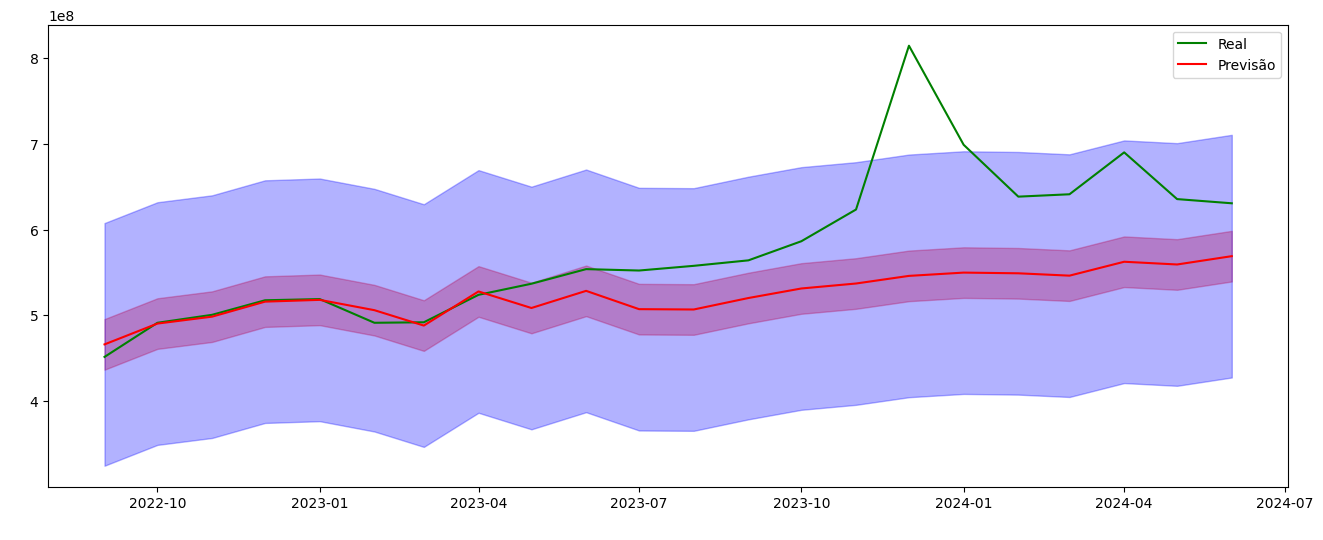

In [61]:
plt.figure(figsize = (16,6))
#plt.title('Previsão do ICMS com base na metodologia de Box-Jenkins', size = 18)
plt.ylabel(' ')
plt.xlabel(' ')
plt.legend(['Valor Real', 'Previsão'])
sns.lineplot(x = df_real.loc[df_real.index >= '2022-09-01'].index,
             y = df_real.loc[df_real.index >= '2022-09-01'].ICMS,
             color = 'green',
             label = 'Real')
sns.lineplot(x = prev_icms_mape.index,
             y = prev_icms_mape['Previsão Modelo 1'],
             color = 'red',
             label = 'Previsão')
plt.fill_between(prev_icms_mape.index, prev_icms_mape['conf_lower'], prev_icms_mape['conf_upper'], alpha = 0.3, color = 'Red')
plt.fill_between(prev_icms_mape.index, prev_icms_mape['pred_lower'], prev_icms_mape['pred_upper'], alpha = 0.3, color = 'Blue')

In [62]:
mape_icms_mape_1 = MAPE(prev_icms_mape['Previsão Modelo 1'], df_real['ICMS'])*100
mape_icms_mape_1

10.446613697501208

### Resultados

In [63]:
print(mape_icms_aic_1)
print(mape_icms_mape_1)

13.641613840330402
10.446613697501208


## IPVA

### AIC

In [64]:
# AIC

sarima_ipva = pm.ARIMA(order = ipva_order_aic, seasonal_order = ipva_seasonal_order_aic, suppress_warnings=True)
sarima_ipva.fit(df_treino['IPVA'])
prev_ipva_aic = sarima_ipva.predict(n_periods= 22, return_conf_int=False)
prev_ipva_aic = pd.DataFrame(prev_ipva_aic, columns=['Previsão Modelo 1'])
# ICMS

# Utilizando z-score de distribuição normal
n = len(prev_ipva_aic)
prev_ipva_aic['error'] = df_real['ICMS'] - prev_ipva_aic['Previsão Modelo 1']
s = prev_ipva_aic['error'].std(ddof=1)
t = stats.t.ppf(0.975, df=n-1)

prev_ipva_aic['conf_interval'] = t * s / np.sqrt(n)
prev_ipva_aic['pred_interval'] = t * s * np.sqrt(1 + 1/n)

# Calculando limites superiores e inferiores para cada previsão
prev_ipva_aic['conf_lower'] = prev_ipva_aic['Previsão Modelo 1'] - prev_ipva_aic['conf_interval']
prev_ipva_aic['conf_upper'] = prev_ipva_aic['Previsão Modelo 1'] + prev_ipva_aic['conf_interval']
prev_ipva_aic['pred_lower'] = prev_ipva_aic['Previsão Modelo 1'] - prev_ipva_aic['pred_interval']
prev_ipva_aic['pred_upper'] = prev_ipva_aic['Previsão Modelo 1'] + prev_ipva_aic['pred_interval']
prev_ipva_aic

,Previsão Modelo 1,error,conf_interval,pred_interval,conf_lower,conf_upper,pred_lower,pred_upper
2022-09-01,3.670067e+07,4.149584e+08,3.628225e+07,1.740035e+08,4.184256e+05,7.298292e+07,-1.373029e+08,2.107042e+08
2022-10-01,3.120794e+07,4.602369e+08,3.628225e+07,1.740035e+08,-5.074308e+06,6.749018e+07,-1.427956e+08,2.052115e+08
2022-11-01,2.801142e+07,4.727460e+08,3.628225e+07,1.740035e+08,-8.270829e+06,6.429366e+07,-1.459921e+08,2.020150e+08
2022-12-01,2.319816e+07,4.945078e+08,3.628225e+07,1.740035e+08,-1.308409e+07,5.948040e+07,-1.508054e+08,1.972017e+08
2023-01-01,8.035831e+07,4.387282e+08,3.628225e+07,1.740035e+08,4.407606e+07,1.166406e+08,-9.364523e+07,2.543618e+08
2023-02-01,4.511965e+07,4.463312e+08,3.628225e+07,1.740035e+08,8.837409e+06,8.140190e+07,-1.288839e+08,2.191232e+08
2023-03-01,6.272246e+07,4.293158e+08,3.628225e+07,1.740035e+08,2.644022e+07,9.900471e+07,-1.112811e+08,2.367260e+08
2023-04-01,6.156699e+07,4.624833e+08,3.628225e+07,1.740035e+08,2.528475e+07,9.784924e+07,-1.124365e+08,2.355705e+08
2023-05-01,7.568496e+07,4.613012e+08,3.628225e+07,1.740035e+08,3.940272e+07,1.119672e+08,-9.831858e+07,2.496885e+08
2023-06-01,7.598562e+07,4.780294e+08,3.628225e+07,1.740035e+08,3.970338e+07,1.122679e+08,-9.801792e+07,2.499892e+08


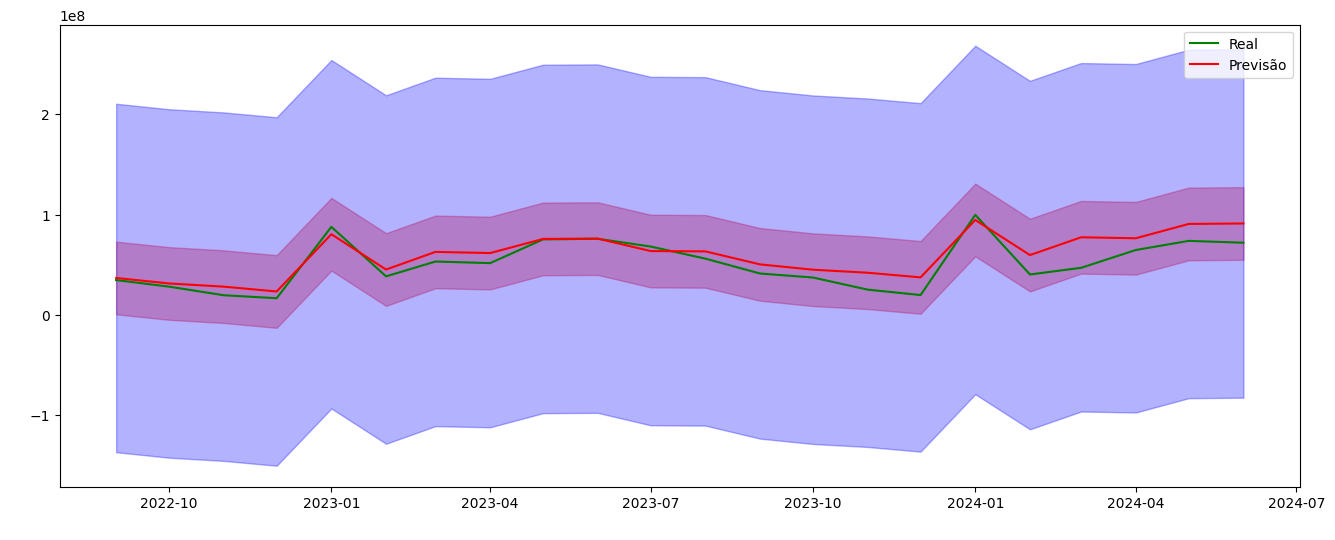

In [65]:
plt.figure(figsize = (16,6))
#plt.title('Previsão do ICMS com base na metodologia de Box-Jenkins', size = 18)
plt.ylabel(' ')
plt.xlabel(' ')
plt.legend(['Valor Real', 'Previsão'])
sns.lineplot(x = df_real.loc[df_real.index >= '2022-09-01'].index,
             y = df_real.loc[df_real.index >= '2022-09-01'].IPVA,
             color = 'green',
             label = 'Real')
sns.lineplot(x = prev_ipva_aic.index,
             y = prev_ipva_aic['Previsão Modelo 1'],
             color = 'red',
             label = 'Previsão')
plt.fill_between(prev_ipva_aic.index, prev_ipva_aic['conf_lower'], prev_ipva_aic['conf_upper'], alpha = 0.3, color = 'Red')
plt.fill_between(prev_ipva_aic.index, prev_ipva_aic['pred_lower'], prev_ipva_aic['pred_upper'], alpha = 0.3, color = 'Blue')

In [66]:
mape_ipva_aic_1 = MAPE(prev_ipva_aic['Previsão Modelo 1'], df_real['IPVA'])*100
mape_ipva_aic_1

18.482077210023597

### MAPE

In [67]:
# MAPE

sarima_ipva = pm.ARIMA(order = ipva_order_mape, seasonal_order = ipva_seasonal_order_mape, suppress_warnings=True)
sarima_ipva.fit(df_treino['IPVA'])
prev_ipva_mape = sarima_ipva.predict(n_periods= 22, return_conf_int=False)
prev_ipva_mape = pd.DataFrame(prev_ipva_mape, columns=['Previsão Modelo 1'])
# ICMS

# Utilizando z-score de distribuição normal
n = len(prev_ipva_mape)
prev_ipva_mape['error'] = df_real['ICMS'] - prev_ipva_mape['Previsão Modelo 1']
s = prev_ipva_mape['error'].std(ddof=1)
t = stats.t.ppf(0.975, df=n-1)

prev_ipva_mape['conf_interval'] = t * s / np.sqrt(n)
prev_ipva_mape['pred_interval'] = t * s * np.sqrt(1 + 1/n)

# Calculando limites superiores e inferiores para cada previsão
prev_ipva_mape['conf_lower'] = prev_ipva_mape['Previsão Modelo 1'] - prev_ipva_mape['conf_interval']
prev_ipva_mape['conf_upper'] = prev_ipva_mape['Previsão Modelo 1'] + prev_ipva_mape['conf_interval']
prev_ipva_mape['pred_lower'] = prev_ipva_mape['Previsão Modelo 1'] - prev_ipva_mape['pred_interval']
prev_ipva_mape['pred_upper'] = prev_ipva_mape['Previsão Modelo 1'] + prev_ipva_mape['pred_interval']
prev_ipva_mape

,Previsão Modelo 1,error,conf_interval,pred_interval,conf_lower,conf_upper,pred_lower,pred_upper
2022-09-01,3.065400e+07,4.210051e+08,3.835544e+07,1.839462e+08,-7.701443e+06,6.900944e+07,-1.532922e+08,2.146002e+08
2022-10-01,2.363481e+07,4.678100e+08,3.835544e+07,1.839462e+08,-1.472063e+07,6.199025e+07,-1.603114e+08,2.075810e+08
2022-11-01,1.960499e+07,4.811524e+08,3.835544e+07,1.839462e+08,-1.875045e+07,5.796043e+07,-1.643412e+08,2.035512e+08
2022-12-01,1.434192e+07,5.033640e+08,3.835544e+07,1.839462e+08,-2.401352e+07,5.269736e+07,-1.696043e+08,1.982882e+08
2023-01-01,7.121590e+07,4.478707e+08,3.835544e+07,1.839462e+08,3.286046e+07,1.095713e+08,-1.127303e+08,2.551621e+08
2023-02-01,3.575783e+07,4.556930e+08,3.835544e+07,1.839462e+08,-2.597611e+06,7.411327e+07,-1.481884e+08,2.197041e+08
2023-03-01,5.316819e+07,4.388701e+08,3.835544e+07,1.839462e+08,1.481275e+07,9.152363e+07,-1.307780e+08,2.371144e+08
2023-04-01,5.183115e+07,4.722192e+08,3.835544e+07,1.839462e+08,1.347571e+07,9.018660e+07,-1.321151e+08,2.357774e+08
2023-05-01,6.577194e+07,4.712143e+08,3.835544e+07,1.839462e+08,2.741650e+07,1.041274e+08,-1.181743e+08,2.497182e+08
2023-06-01,6.589718e+07,4.881179e+08,3.835544e+07,1.839462e+08,2.754174e+07,1.042526e+08,-1.180491e+08,2.498434e+08


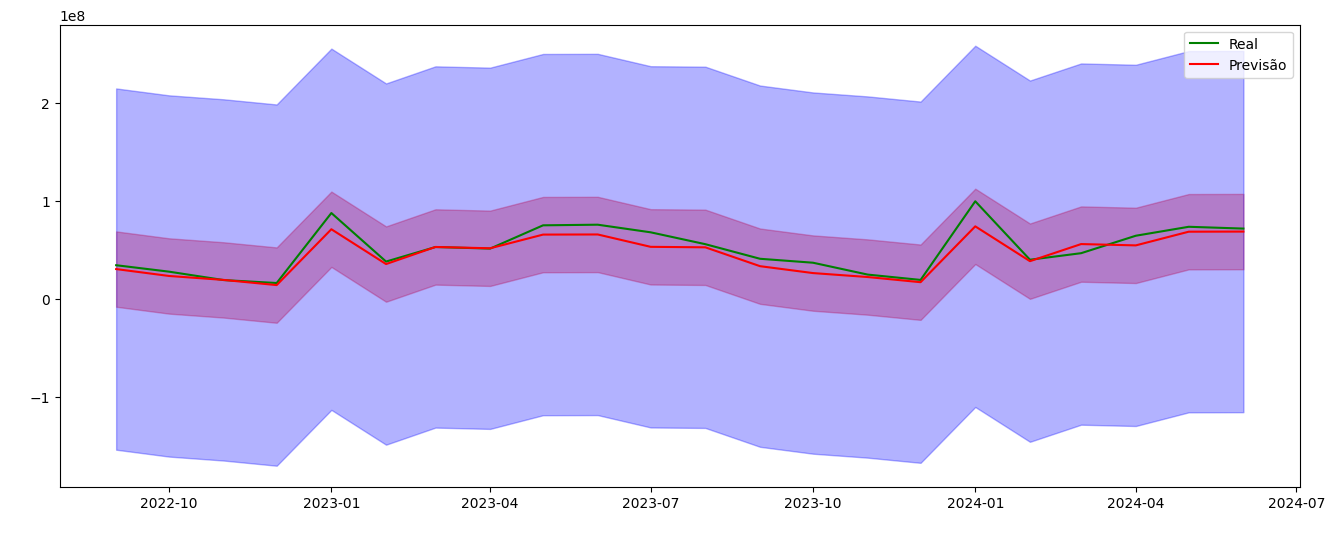

In [68]:
plt.figure(figsize = (16,6))
#plt.title('Previsão do ICMS com base na metodologia de Box-Jenkins', size = 18)
plt.ylabel(' ')
plt.xlabel(' ')
plt.legend(['Valor Real', 'Previsão'])
sns.lineplot(x = df_real.loc[df_real.index >= '2022-09-01'].index,
             y = df_real.loc[df_real.index >= '2022-09-01'].IPVA,
             color = 'green',
             label = 'Real')
sns.lineplot(x = prev_ipva_mape.index,
             y = prev_ipva_mape['Previsão Modelo 1'],
             color = 'red',
             label = 'Previsão')
plt.fill_between(prev_ipva_mape.index, prev_ipva_mape['conf_lower'], prev_ipva_mape['conf_upper'], alpha = 0.3, color = 'Red')
plt.fill_between(prev_ipva_mape.index, prev_ipva_mape['pred_lower'], prev_ipva_mape['pred_upper'], alpha = 0.3, color = 'Blue')

In [69]:
mape_ipva_mape_1 = MAPE(prev_ipva_mape['Previsão Modelo 1'], df_real['IPVA'])*100
mape_ipva_mape_1

14.192660394095165

### Resultados

In [70]:
print(mape_ipva_aic_1)
print(mape_ipva_mape_1)

18.482077210023597
14.192660394095165


# TESTE 2 (CORTE EM FEV 23 - 16 MESES PRA FRENTE)

## ICMS

In [71]:
# treino e real
df_treino = df.loc[(df.index >= '2008-01-01') & (df.index <= '2023-02-01')]
df_real = df.loc[(df.index >= '2023-03-01')]

In [72]:
# ICMS
icms_order_aic = (0,1,1)
icms_seasonal_order_aic = (0,1,1,12)
icms_order_mape = (1,1,1)
icms_seasonal_order_mape = (1,0,0,12)
# IPVA
ipva_order_aic = (1,1,1)
ipva_seasonal_order_aic = (0,1,0,12)
ipva_order_mape = (1,0,1)
ipva_seasonal_order_mape = (0,1,0,12)

### AIC

In [73]:
# AIC

sarima_icms = pm.ARIMA(order = icms_order_aic, seasonal_order = icms_seasonal_order_aic, suppress_warnings=True)
sarima_icms.fit(df_treino['ICMS'])
prev_icms_aic = sarima_icms.predict(n_periods= 16, return_conf_int=False)
prev_icms_aic = pd.DataFrame(prev_icms_aic, columns=['Previsão Modelo 1'])
# ICMS

# Utilizando z-score de distribuição normal
n = len(prev_icms_aic)
prev_icms_aic['error'] = df_real['ICMS'] - prev_icms_aic['Previsão Modelo 1']
s = prev_icms_aic['error'].std(ddof=1)
t = stats.t.ppf(0.975, df=n-1)

prev_icms_aic['conf_interval'] = t * s / np.sqrt(n)
prev_icms_aic['pred_interval'] = t * s * np.sqrt(1 + 1/n)

# Calculando limites superiores e inferiores para cada previsão
prev_icms_aic['conf_lower'] = prev_icms_aic['Previsão Modelo 1'] - prev_icms_aic['conf_interval']
prev_icms_aic['conf_upper'] = prev_icms_aic['Previsão Modelo 1'] + prev_icms_aic['conf_interval']
prev_icms_aic['pred_lower'] = prev_icms_aic['Previsão Modelo 1'] - prev_icms_aic['pred_interval']
prev_icms_aic['pred_upper'] = prev_icms_aic['Previsão Modelo 1'] + prev_icms_aic['pred_interval']
prev_icms_aic

,Previsão Modelo 1,error,conf_interval,pred_interval,conf_lower,conf_upper,pred_lower,pred_upper
2023-03-01,4.444494e+08,4.758891e+07,3.065983e+07,1.264137e+08,4.137895e+08,4.751092e+08,3.180357e+08,5.708631e+08
2023-04-01,4.745096e+08,4.954076e+07,3.065983e+07,1.264137e+08,4.438497e+08,5.051694e+08,3.480958e+08,6.009233e+08
2023-05-01,4.509159e+08,8.607030e+07,3.065983e+07,1.264137e+08,4.202561e+08,4.815757e+08,3.245022e+08,5.773296e+08
2023-06-01,4.645371e+08,8.947799e+07,3.065983e+07,1.264137e+08,4.338772e+08,4.951969e+08,3.381234e+08,5.909508e+08
2023-07-01,4.518955e+08,1.004921e+08,3.065983e+07,1.264137e+08,4.212356e+08,4.825553e+08,3.254818e+08,5.783092e+08
2023-08-01,4.651864e+08,9.266929e+07,3.065983e+07,1.264137e+08,4.345266e+08,4.958463e+08,3.387727e+08,5.916002e+08
2023-09-01,4.663323e+08,9.791639e+07,3.065983e+07,1.264137e+08,4.356725e+08,4.969922e+08,3.399186e+08,5.927461e+08
2023-10-01,4.959975e+08,9.053130e+07,3.065983e+07,1.264137e+08,4.653377e+08,5.266574e+08,3.695838e+08,6.224113e+08
2023-11-01,5.136224e+08,1.099060e+08,3.065983e+07,1.264137e+08,4.829625e+08,5.442822e+08,3.872087e+08,6.400361e+08
2023-12-01,5.521859e+08,2.623266e+08,3.065983e+07,1.264137e+08,5.215260e+08,5.828457e+08,4.257721e+08,6.785996e+08


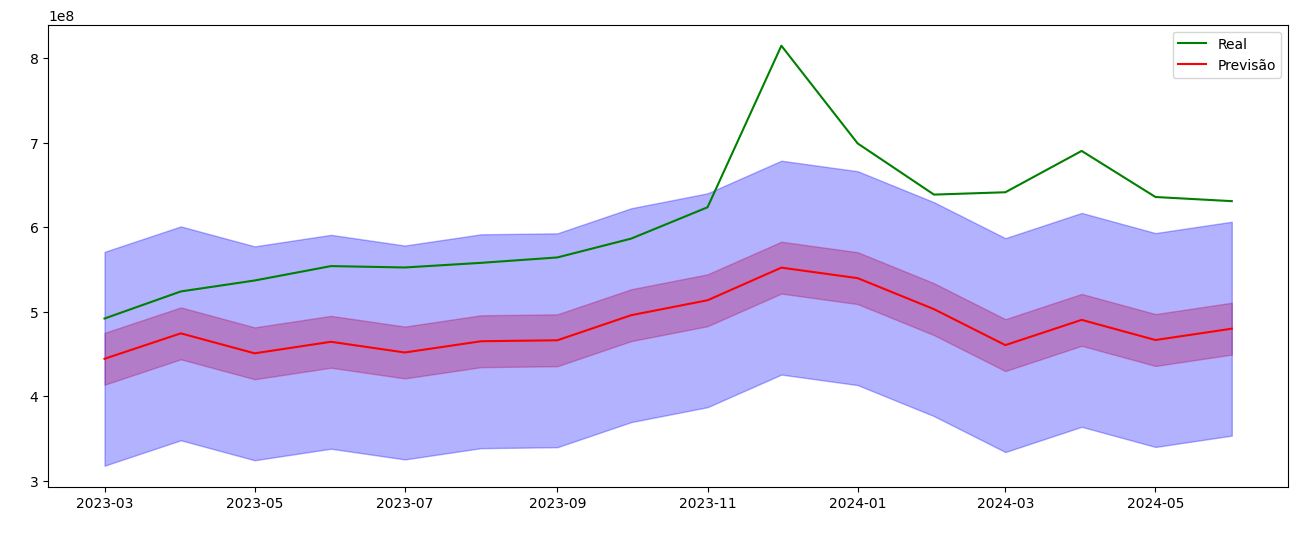

In [74]:
plt.figure(figsize = (16,6))
#plt.title('Previsão do ICMS com base na metodologia de Box-Jenkins', size = 18)
plt.ylabel(' ')
plt.xlabel(' ')
plt.legend(['Valor Real', 'Previsão'])
sns.lineplot(x = df_real.loc[df_real.index >= '2022-09-01'].index,
             y = df_real.loc[df_real.index >= '2022-09-01'].ICMS,
             color = 'green',
             label = 'Real')
sns.lineplot(x = prev_icms_aic.index,
             y = prev_icms_aic['Previsão Modelo 1'],
             color = 'red',
             label = 'Previsão')
plt.fill_between(prev_icms_aic.index, prev_icms_aic['conf_lower'], prev_icms_aic['conf_upper'], alpha = 0.3, color = 'Red')
plt.fill_between(prev_icms_aic.index, prev_icms_aic['pred_lower'], prev_icms_aic['pred_upper'], alpha = 0.3, color = 'Blue')

In [75]:
mape_icms_aic_2 = MAPE(prev_icms_aic['Previsão Modelo 1'], df_real['ICMS'])*100
mape_icms_aic_2

25.8637060475148

### MAPE

In [76]:
# MAPE

sarima_icms = pm.ARIMA(order = icms_order_mape, seasonal_order = icms_seasonal_order_mape, suppress_warnings=True)
sarima_icms.fit(df_treino['ICMS'])
prev_icms_mape = sarima_icms.predict(n_periods= 16, return_conf_int=False)
prev_icms_mape = pd.DataFrame(prev_icms_mape, columns=['Previsão Modelo 1'])
# ICMS

# Utilizando z-score de distribuição normal
n = len(prev_icms_mape)
prev_icms_mape['error'] = df_real['ICMS'] - prev_icms_mape['Previsão Modelo 1']
s = prev_icms_mape['error'].std(ddof=1)
t = stats.t.ppf(0.975, df=n-1)

prev_icms_mape['conf_interval'] = t * s / np.sqrt(n)
prev_icms_mape['pred_interval'] = t * s * np.sqrt(1 + 1/n)

# Calculando limites superiores e inferiores para cada previsão
prev_icms_mape['conf_lower'] = prev_icms_mape['Previsão Modelo 1'] - prev_icms_mape['conf_interval']
prev_icms_mape['conf_upper'] = prev_icms_mape['Previsão Modelo 1'] + prev_icms_mape['conf_interval']
prev_icms_mape['pred_lower'] = prev_icms_mape['Previsão Modelo 1'] - prev_icms_mape['pred_interval']
prev_icms_mape['pred_upper'] = prev_icms_mape['Previsão Modelo 1'] + prev_icms_mape['pred_interval']
prev_icms_mape

,Previsão Modelo 1,error,conf_interval,pred_interval,conf_lower,conf_upper,pred_lower,pred_upper
2023-03-01,4.792468e+08,1.279147e+07,3.469639e+07,1.430569e+08,4.445504e+08,5.139432e+08,3.361899e+08,6.223037e+08
2023-04-01,5.218776e+08,2.172751e+06,3.469639e+07,1.430569e+08,4.871812e+08,5.565740e+08,3.788207e+08,6.649345e+08
2023-05-01,5.021148e+08,3.487135e+07,3.469639e+07,1.430569e+08,4.674184e+08,5.368112e+08,3.590580e+08,6.451717e+08
2023-06-01,5.230195e+08,3.099554e+07,3.469639e+07,1.430569e+08,4.883231e+08,5.577159e+08,3.799626e+08,6.660764e+08
2023-07-01,5.009261e+08,5.146142e+07,3.469639e+07,1.430569e+08,4.662297e+08,5.356225e+08,3.578692e+08,6.439830e+08
2023-08-01,5.005956e+08,5.726017e+07,3.469639e+07,1.430569e+08,4.658992e+08,5.352919e+08,3.575387e+08,6.436524e+08
2023-09-01,5.096186e+08,5.463014e+07,3.469639e+07,1.430569e+08,4.749222e+08,5.443150e+08,3.665617e+08,6.526755e+08
2023-10-01,5.265563e+08,5.997252e+07,3.469639e+07,1.430569e+08,4.918599e+08,5.612527e+08,3.834994e+08,6.696132e+08
2023-11-01,5.330904e+08,9.043791e+07,3.469639e+07,1.430569e+08,4.983940e+08,5.677868e+08,3.900335e+08,6.761473e+08
2023-12-01,5.422314e+08,2.722810e+08,3.469639e+07,1.430569e+08,5.075350e+08,5.769278e+08,3.991746e+08,6.852883e+08


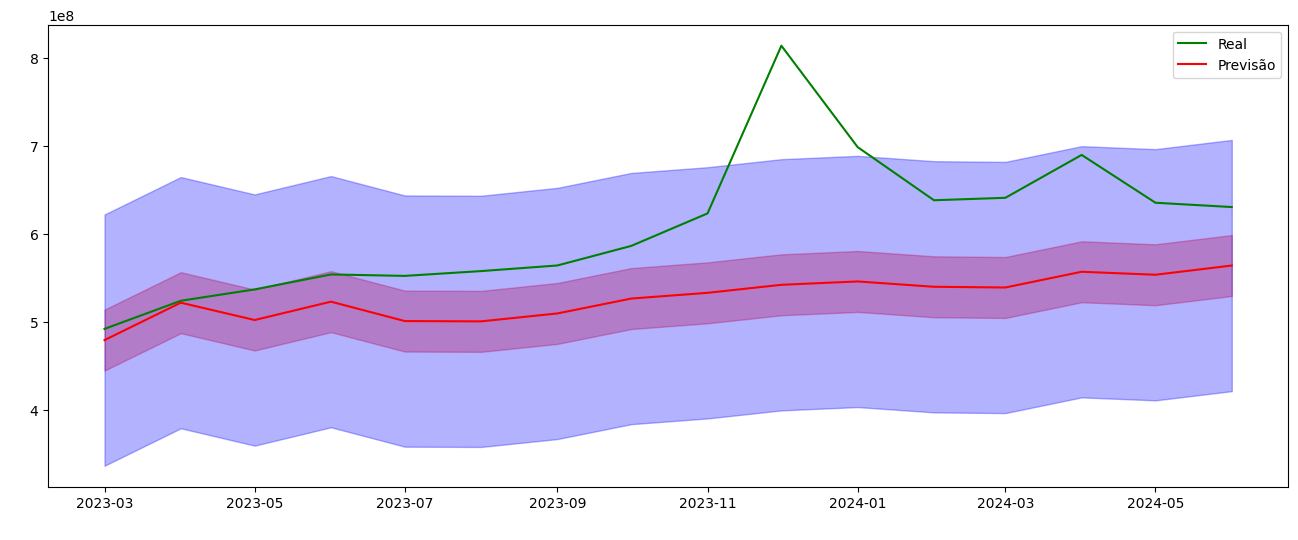

In [77]:
plt.figure(figsize = (16,6))
#plt.title('Previsão do ICMS com base na metodologia de Box-Jenkins', size = 18)
plt.ylabel(' ')
plt.xlabel(' ')
plt.legend(['Valor Real', 'Previsão'])
sns.lineplot(x = df_real.loc[df_real.index >= '2022-09-01'].index,
             y = df_real.loc[df_real.index >= '2022-09-01'].ICMS,
             color = 'green',
             label = 'Real')
sns.lineplot(x = prev_icms_mape.index,
             y = prev_icms_mape['Previsão Modelo 1'],
             color = 'red',
             label = 'Previsão')
plt.fill_between(prev_icms_mape.index, prev_icms_mape['conf_lower'], prev_icms_mape['conf_upper'], alpha = 0.3, color = 'Red')
plt.fill_between(prev_icms_mape.index, prev_icms_mape['pred_lower'], prev_icms_mape['pred_upper'], alpha = 0.3, color = 'Blue')

In [78]:
mape_icms_mape_2 = MAPE(prev_icms_mape['Previsão Modelo 1'], df_real['ICMS'])*100
mape_icms_mape_2

15.166742809015144

### Resultados

In [79]:
print(mape_icms_aic_2)
print(mape_icms_mape_2)

25.8637060475148
15.166742809015144


## IPVA

### AIC

In [80]:
# AIC

sarima_ipva = pm.ARIMA(order = ipva_order_aic, seasonal_order = ipva_seasonal_order_aic, suppress_warnings=True)
sarima_ipva.fit(df_treino['IPVA'])
prev_ipva_aic = sarima_ipva.predict(n_periods= 16, return_conf_int=False)
prev_ipva_aic = pd.DataFrame(prev_ipva_aic, columns=['Previsão Modelo 1'])
# ICMS

# Utilizando z-score de distribuição normal
n = len(prev_ipva_aic)
prev_ipva_aic['error'] = df_real['ICMS'] - prev_ipva_aic['Previsão Modelo 1']
s = prev_ipva_aic['error'].std(ddof=1)
t = stats.t.ppf(0.975, df=n-1)

prev_ipva_aic['conf_interval'] = t * s / np.sqrt(n)
prev_ipva_aic['pred_interval'] = t * s * np.sqrt(1 + 1/n)

# Calculando limites superiores e inferiores para cada previsão
prev_ipva_aic['conf_lower'] = prev_ipva_aic['Previsão Modelo 1'] - prev_ipva_aic['conf_interval']
prev_ipva_aic['conf_upper'] = prev_ipva_aic['Previsão Modelo 1'] + prev_ipva_aic['conf_interval']
prev_ipva_aic['pred_lower'] = prev_ipva_aic['Previsão Modelo 1'] - prev_ipva_aic['pred_interval']
prev_ipva_aic['pred_upper'] = prev_ipva_aic['Previsão Modelo 1'] + prev_ipva_aic['pred_interval']
prev_ipva_aic

,Previsão Modelo 1,error,conf_interval,pred_interval,conf_lower,conf_upper,pred_lower,pred_upper
2023-03-01,5.955018e+07,4.324881e+08,4.514014e+07,1.861176e+08,1.441005e+07,1.046903e+08,-1.265674e+08,2.456677e+08
2023-04-01,5.874581e+07,4.653045e+08,4.514014e+07,1.861176e+08,1.360568e+07,1.038860e+08,-1.273717e+08,2.448634e+08
2023-05-01,7.285366e+07,4.641325e+08,4.514014e+07,1.861176e+08,2.771352e+07,1.179938e+08,-1.132639e+08,2.589712e+08
2023-06-01,7.310461e+07,4.809105e+08,4.514014e+07,1.861176e+08,2.796448e+07,1.182448e+08,-1.130129e+08,2.592222e+08
2023-07-01,6.063276e+07,4.917548e+08,4.514014e+07,1.861176e+08,1.549262e+07,1.057729e+08,-1.254848e+08,2.467503e+08
2023-08-01,6.025870e+07,4.975970e+08,4.514014e+07,1.861176e+08,1.511856e+07,1.053988e+08,-1.258589e+08,2.463763e+08
2023-09-01,4.509791e+07,5.191508e+08,4.514014e+07,1.861176e+08,-4.222661e+04,9.023805e+07,-1.410196e+08,2.312155e+08
2023-10-01,3.865591e+07,5.478729e+08,4.514014e+07,1.861176e+08,-6.484223e+06,8.379605e+07,-1.474616e+08,2.247735e+08
2023-11-01,3.020028e+07,5.933281e+08,4.514014e+07,1.861176e+08,-1.493986e+07,7.534042e+07,-1.559173e+08,2.163178e+08
2023-12-01,2.733664e+07,7.871758e+08,4.514014e+07,1.861176e+08,-1.780349e+07,7.247678e+07,-1.587809e+08,2.134542e+08


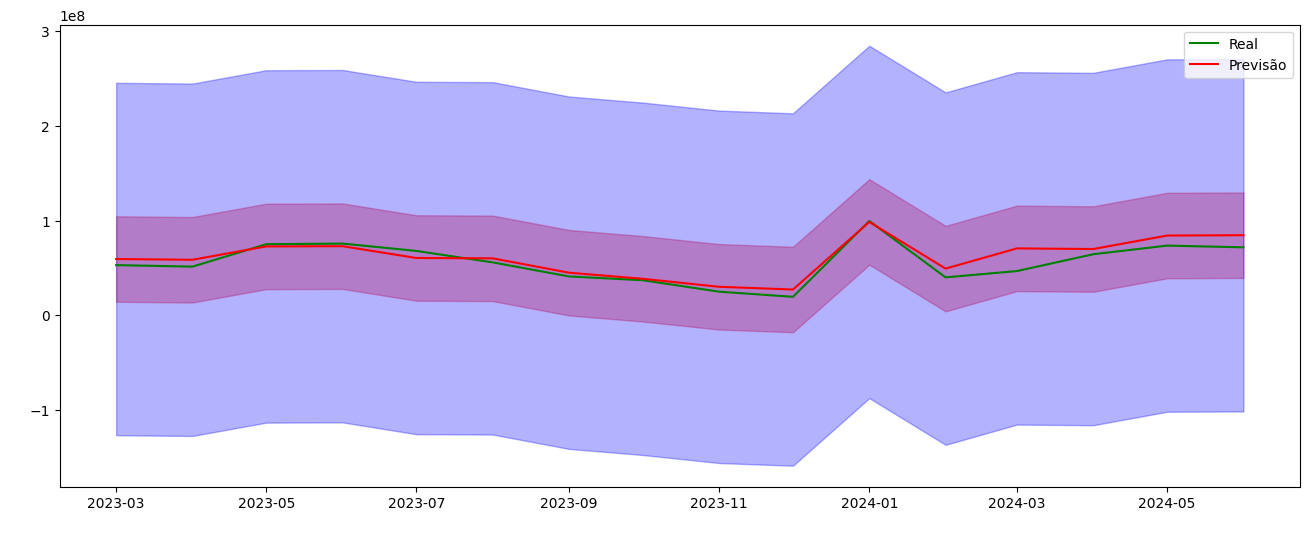

In [81]:
plt.figure(figsize = (16,6))
#plt.title('Previsão do ICMS com base na metodologia de Box-Jenkins', size = 18)
plt.ylabel(' ')
plt.xlabel(' ')
plt.legend(['Valor Real', 'Previsão'])
sns.lineplot(x = df_real.loc[df_real.index >= '2022-09-01'].index,
             y = df_real.loc[df_real.index >= '2022-09-01'].IPVA,
             color = 'green',
             label = 'Real')
sns.lineplot(x = prev_ipva_aic.index,
             y = prev_ipva_aic['Previsão Modelo 1'],
             color = 'red',
             label = 'Previsão')
plt.fill_between(prev_ipva_aic.index, prev_ipva_aic['conf_lower'], prev_ipva_aic['conf_upper'], alpha = 0.3, color = 'Red')
plt.fill_between(prev_ipva_aic.index, prev_ipva_aic['pred_lower'], prev_ipva_aic['pred_upper'], alpha = 0.3, color = 'Blue')

In [82]:
mape_ipva_aic_2 = MAPE(prev_ipva_aic['Previsão Modelo 1'], df_real['IPVA'])*100
mape_ipva_aic_2

12.285554597433974

### MAPE

In [83]:
# MAPE

sarima_ipva = pm.ARIMA(order = ipva_order_mape, seasonal_order = ipva_seasonal_order_mape, suppress_warnings=True)
sarima_ipva.fit(df_treino['IPVA'])
prev_ipva_mape = sarima_ipva.predict(n_periods= 16, return_conf_int=False)
prev_ipva_mape = pd.DataFrame(prev_ipva_mape, columns=['Previsão Modelo 1'])
# ICMS

# Utilizando z-score de distribuição normal
n = len(prev_ipva_mape)
prev_ipva_mape['error'] = df_real['ICMS'] - prev_ipva_mape['Previsão Modelo 1']
s = prev_ipva_mape['error'].std(ddof=1)
t = stats.t.ppf(0.975, df=n-1)

prev_ipva_mape['conf_interval'] = t * s / np.sqrt(n)
prev_ipva_mape['pred_interval'] = t * s * np.sqrt(1 + 1/n)

# Calculando limites superiores e inferiores para cada previsão
prev_ipva_mape['conf_lower'] = prev_ipva_mape['Previsão Modelo 1'] - prev_ipva_mape['conf_interval']
prev_ipva_mape['conf_upper'] = prev_ipva_mape['Previsão Modelo 1'] + prev_ipva_mape['conf_interval']
prev_ipva_mape['pred_lower'] = prev_ipva_mape['Previsão Modelo 1'] - prev_ipva_mape['pred_interval']
prev_ipva_mape['pred_upper'] = prev_ipva_mape['Previsão Modelo 1'] + prev_ipva_mape['pred_interval']
prev_ipva_mape

,Previsão Modelo 1,error,conf_interval,pred_interval,conf_lower,conf_upper,pred_lower,pred_upper
2023-03-01,5.464031e+07,4.373980e+08,4.571575e+07,1.884909e+08,8.924558e+06,1.003561e+08,-1.338506e+08,2.431312e+08
2023-04-01,5.259843e+07,4.714519e+08,4.571575e+07,1.884909e+08,6.882684e+06,9.831418e+07,-1.358924e+08,2.410893e+08
2023-05-01,6.623516e+07,4.707510e+08,4.571575e+07,1.884909e+08,2.051941e+07,1.119509e+08,-1.222557e+08,2.547260e+08
2023-06-01,6.622925e+07,4.877858e+08,4.571575e+07,1.884909e+08,2.051350e+07,1.119450e+08,-1.222616e+08,2.547201e+08
2023-07-01,5.358015e+07,4.988074e+08,4.571575e+07,1.884909e+08,7.864402e+06,9.929590e+07,-1.349107e+08,2.420710e+08
2023-08-01,5.306179e+07,5.047939e+08,4.571575e+07,1.884909e+08,7.346038e+06,9.877754e+07,-1.354291e+08,2.415526e+08
2023-09-01,3.777074e+07,5.264780e+08,4.571575e+07,1.884909e+08,-7.945007e+06,8.348649e+07,-1.507201e+08,2.262616e+08
2023-10-01,3.120453e+07,5.553243e+08,4.571575e+07,1.884909e+08,-1.451122e+07,7.692027e+07,-1.572863e+08,2.196954e+08
2023-11-01,2.262727e+07,6.009011e+08,4.571575e+07,1.884909e+08,-2.308848e+07,6.834302e+07,-1.658636e+08,2.111181e+08
2023-12-01,1.964314e+07,7.948693e+08,4.571575e+07,1.884909e+08,-2.607261e+07,6.535889e+07,-1.688477e+08,2.081340e+08


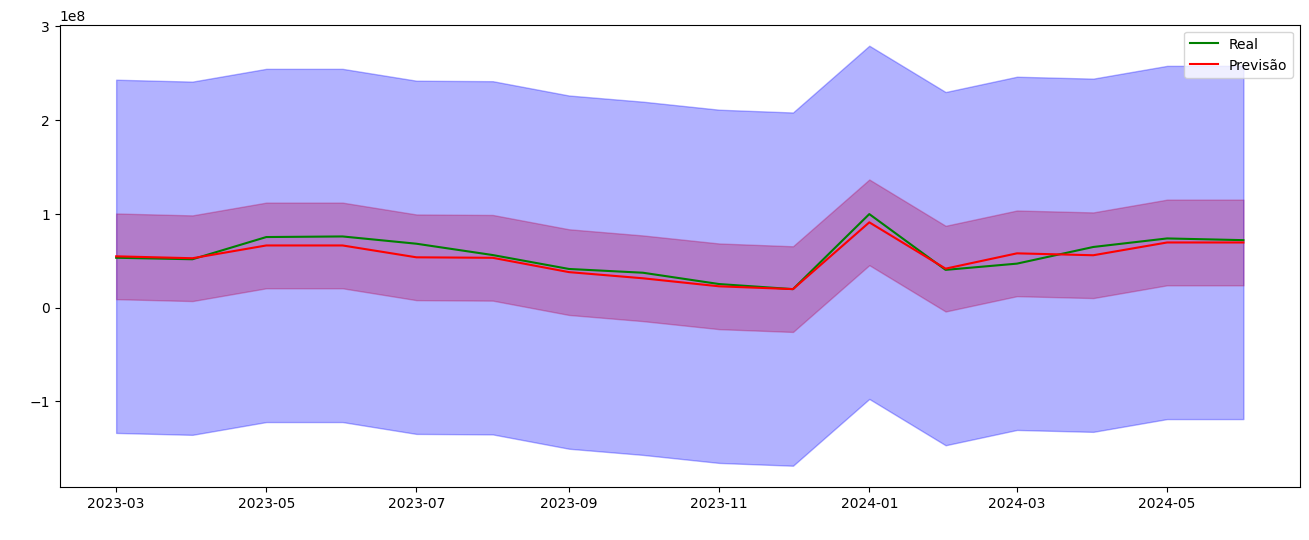

In [84]:
plt.figure(figsize = (16,6))
#plt.title('Previsão do ICMS com base na metodologia de Box-Jenkins', size = 18)
plt.ylabel(' ')
plt.xlabel(' ')
plt.legend(['Valor Real', 'Previsão'])
sns.lineplot(x = df_real.loc[df_real.index >= '2022-09-01'].index,
             y = df_real.loc[df_real.index >= '2022-09-01'].IPVA,
             color = 'green',
             label = 'Real')
sns.lineplot(x = prev_ipva_mape.index,
             y = prev_ipva_mape['Previsão Modelo 1'],
             color = 'red',
             label = 'Previsão')
plt.fill_between(prev_ipva_mape.index, prev_ipva_mape['conf_lower'], prev_ipva_mape['conf_upper'], alpha = 0.3, color = 'Red')
plt.fill_between(prev_ipva_mape.index, prev_ipva_mape['pred_lower'], prev_ipva_mape['pred_upper'], alpha = 0.3, color = 'Blue')

In [85]:
mape_ipva_mape_2 = MAPE(prev_ipva_mape['Previsão Modelo 1'], df_real['IPVA'])*100
mape_ipva_mape_2

10.10860855653035

### Resultados

In [86]:
print(mape_ipva_aic_2)
print(mape_ipva_mape_2)

12.285554597433974
10.10860855653035


# Resultados finais

## TESTE 1

### ICMS

In [87]:
print(f'MODELO 1 (AIC): {mape_icms_aic_1.round(2)}')
print(f'MODELO 2 (MAPE): {mape_icms_mape_1.round(2)}')
print(f'Diferença: {(mape_icms_aic_1-mape_icms_mape_1).round(2)}')

MODELO 1 (AIC): 13.64
MODELO 2 (MAPE): 10.45
Diferença: 3.2


### IPVA

In [88]:
print(f'MODELO 1 (AIC): {mape_ipva_aic_1.round(2)}')
print(f'MODELO 2 (MAPE): {mape_ipva_mape_1.round(2)}')
print(f'Diferença: {(mape_ipva_aic_1-mape_ipva_mape_1).round(2)}')

MODELO 1 (AIC): 18.48
MODELO 2 (MAPE): 14.19
Diferença: 4.29


## TESTE 2

### ICMS

In [89]:
print(f'MODELO 1 (AIC): {mape_icms_aic_2.round(2)}')
print(f'MODELO 2 (MAPE): {mape_icms_mape_2.round(2)}')
print(f'Diferença: {(mape_icms_aic_2-mape_icms_mape_2).round(2)}')

MODELO 1 (AIC): 25.86
MODELO 2 (MAPE): 15.17
Diferença: 10.7


### IPVA

In [90]:
print(f'MODELO 1 (AIC): {mape_ipva_aic_2.round(2)}')
print(f'MODELO 2 (MAPE): {mape_ipva_mape_2.round(2)}')
print(f'Diferença: {(mape_ipva_aic_2-mape_ipva_mape_2).round(2)}')

MODELO 1 (AIC): 12.29
MODELO 2 (MAPE): 10.11
Diferença: 2.18


# Print único

In [91]:
print('TESTE 1 (MESMO CORTE TEMPORAL COM 22 OBS PRA FRENTE)')
print('')
print('ICMS')
print(f'MODELO 1 (AIC): {mape_icms_aic_1.round(2)}')
print(f'MODELO 2 (MAPE): {mape_icms_mape_1.round(2)}')
print(f'Diferença: {(mape_icms_aic_1-mape_icms_mape_1).round(2)}')
print('')
print('IPVA')
print(f'MODELO 1 (AIC): {mape_ipva_aic_1.round(2)}')
print(f'MODELO 2 (MAPE): {mape_ipva_mape_1.round(2)}')
print(f'Diferença: {(mape_ipva_aic_1-mape_ipva_mape_1).round(2)}')
print('')
print('TESTE 2 (CORTE EM FEV 23 - 16 MESES PRA FRENTE)')
print('')
print('ICMS')
print(f'MODELO 1 (AIC): {mape_icms_aic_2.round(2)}')
print(f'MODELO 2 (MAPE): {mape_icms_mape_2.round(2)}')
print(f'Diferença: {(mape_icms_aic_2-mape_icms_mape_2).round(2)}')
print('')
print('IPVA')
print(f'MODELO 1 (AIC): {mape_ipva_aic_2.round(2)}')
print(f'MODELO 2 (MAPE): {mape_ipva_mape_2.round(2)}')
print(f'Diferença: {(mape_ipva_aic_2-mape_ipva_mape_2).round(2)}')

TESTE 1 (MESMO CORTE TEMPORAL COM 22 OBS PRA FRENTE)

ICMS
MODELO 1 (AIC): 13.64
MODELO 2 (MAPE): 10.45
Diferença: 3.2

IPVA
MODELO 1 (AIC): 18.48
MODELO 2 (MAPE): 14.19
Diferença: 4.29

TESTE 2 (CORTE EM FEV 23 - 16 MESES PRA FRENTE)

ICMS
MODELO 1 (AIC): 25.86
MODELO 2 (MAPE): 15.17
Diferença: 10.7

IPVA
MODELO 1 (AIC): 12.29
MODELO 2 (MAPE): 10.11
Diferença: 2.18
